In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import cosine_similarity
from textblob import TextBlob
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score


In [4]:
transactions = pd.read_csv('transactions.csv')
feedback = pd.read_csv('customer_feedback.csv')

In [5]:
transactions.dropna(inplace=True)
feedback.dropna(inplace=True)
transactions['transaction_date'] = pd.to_datetime(transactions['transaction_date'])
feedback['date'] = pd.to_datetime(feedback['date'])

In [6]:
customer_data = transactions.groupby('customer_id').agg({
    'transaction_amount': ['sum', 'mean'],
    'transaction_date': 'count'
}).reset_index()
customer_data.columns = ['customer_id', 'total_spent', 'average_spent', 'transaction_count']

kmeans = KMeans(n_clusters=4, random_state=0)
customer_data['segment'] = kmeans.fit_predict(customer_data[['total_spent', 'average_spent', 'transaction_count']])


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


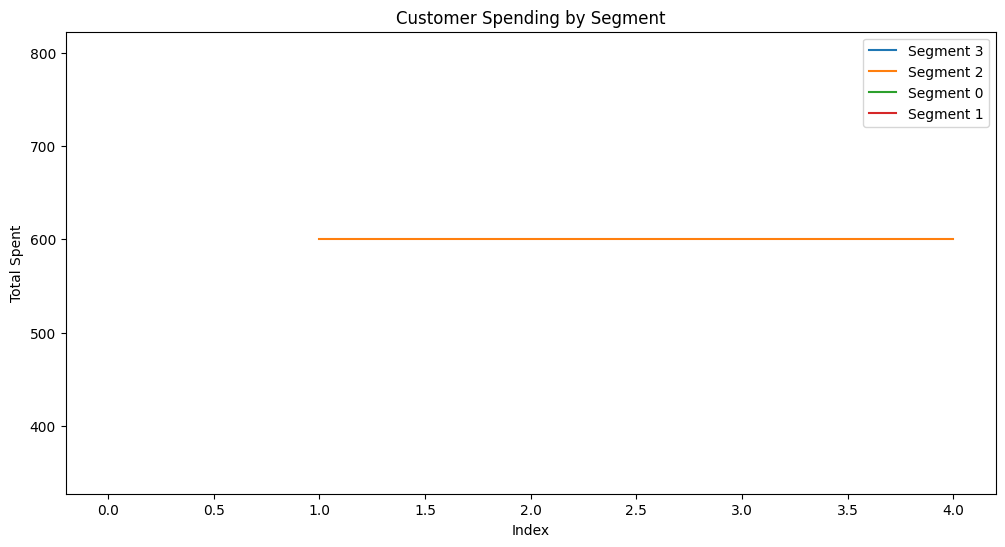

In [7]:
plt.figure(figsize=(12, 6))
for segment in customer_data['segment'].unique():
    segment_data = customer_data[customer_data['segment'] == segment]
    plt.plot(segment_data.index, segment_data['total_spent'], label=f'Segment {segment}')

plt.xlabel('Index')
plt.ylabel('Total Spent')
plt.title('Customer Spending by Segment')
plt.legend()
plt.show()

In [8]:
product_data = transactions.pivot_table(index='customer_id', columns='product_id', values='transaction_amount', fill_value=0)
product_similarity = cosine_similarity(product_data)

def recommend_products(customer_id, product_data, product_similarity, n_recommendations=5):
    customer_idx = product_data.index.get_loc(customer_id)
    similarity_scores = product_similarity[customer_idx]
    product_indices = similarity_scores.argsort()[-n_recommendations:][::-1]
    recommended_products = product_data.columns[product_indices]
    return recommended_products

In [9]:
customer_id = 1  # Change this to test with different customers
recommended_products = recommend_products(customer_id, product_data, product_similarity)
print(f'Recommended products for customer {customer_id}: {recommended_products}')

Recommended products for customer 1: Index([101, 104, 102, 103, 105], dtype='int64', name='product_id')


In [10]:
def analyze_sentiment(feedback_text):
    analysis = TextBlob(feedback_text)
    if analysis.sentiment.polarity > 0:
        return 'Positive'
    elif analysis.sentiment.polarity < 0:
        return 'Negative'
    else:
        return 'Neutral'

feedback['sentiment'] = feedback['feedback'].apply(analyze_sentiment)
print(feedback[['feedback', 'sentiment']].head())

                               feedback sentiment
0                The service was great!  Positive
1  Had some issues with my transaction.   Neutral
2      Very satisfied with the support.  Positive
3        Not happy with the new policy.  Negative
4           Excellent customer service.  Positive


In [11]:
feedback['transaction_count'] = feedback['customer_id'].map(customer_data.set_index('customer_id')['transaction_count'])
feedback['total_spent'] = feedback['customer_id'].map(customer_data.set_index('customer_id')['total_spent'])
feedback['average_spent'] = feedback['customer_id'].map(customer_data.set_index('customer_id')['average_spent'])

X = feedback[['transaction_count', 'total_spent', 'average_spent']]
y = feedback['campaign_response']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f'Model Accuracy: {accuracy * 100:.2f}%')

new_campaign_data = pd.DataFrame({
    'transaction_count': [5, 15, 30],
    'total_spent': [500, 2000, 5000],
    'average_spent': [100, 133.33, 166.67]
})

new_campaign_predictions = model.predict(new_campaign_data)
print('Campaign Response Predictions:', new_campaign_predictions)

Model Accuracy: 50.00%
Campaign Response Predictions: [1 1 1]
